In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = h5py.File('C:/Users/DELL-PC/Downloads/archive (13)/Signs_Data_Training.h5')
test_data = h5py.File('C:/Users/DELL-PC/Downloads/archive (13)/Signs_Data_Testing.h5')

In [3]:
train_data.keys(), test_data.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [4]:
X_train = train_data['train_set_x']
Y_train = train_data['train_set_y']
X_test = test_data['test_set_x']
Y_test = test_data['test_set_y']

In [5]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

# Quality Check

2


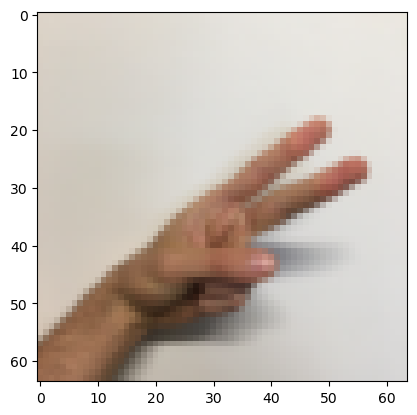

In [6]:
index = 222
plt.imshow(X_train[index])
print(Y_train[index])

1


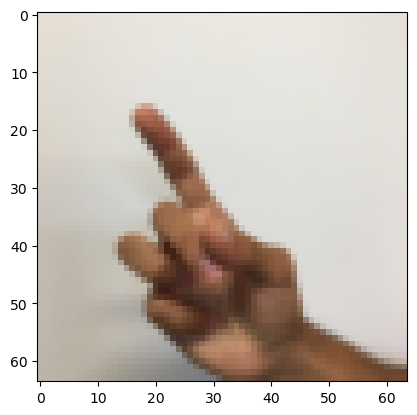

In [7]:
index = 777
plt.imshow(X_train[index])
print(Y_train[index])

In [8]:
X_train

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

In [9]:
# Change it to numpy array 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [10]:
X_train = X_train.reshape(1080, -1)
X_train = pd.DataFrame(X_train)

X_test = X_test.reshape(120, -1)
X_test = pd.DataFrame(X_test)

Y_train = pd.DataFrame(Y_train)

Y_test = pd.DataFrame(Y_test)

In [11]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,227,220,214,227,221,215,227,222,215,227,...,210,209,210,210,209,210,209,208,209,209
1,238,232,223,238,232,223,238,232,223,237,...,193,214,203,194,215,203,194,215,204,192
2,228,220,208,228,220,208,227,219,208,227,...,198,208,204,200,210,206,201,211,207,202
3,228,219,208,229,219,208,228,220,208,227,...,193,199,194,194,200,195,193,201,196,193
4,225,217,204,225,218,205,225,218,206,225,...,203,205,202,201,202,199,198,199,195,192


In [12]:
# Check if pixel values are in the range between 0 and 255
for i in range(X_train.shape[1]):
    for j in range(X_train.shape[0]):
        if X_train[i][j]>255:
            print("Error at i= " +str(i) + " and j= " + str(j))

# EDA

In [13]:
Y_train.columns = ['Label']

In [14]:
Y_test.columns = ['Label']

<Axes: ylabel='count'>

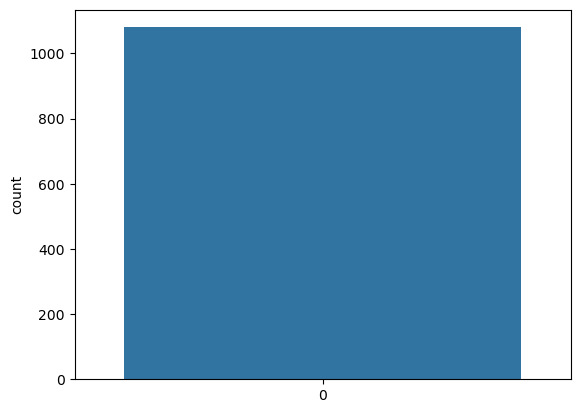

In [15]:
# Countplot of labels to see if the data is imbalanced
sns.countplot(Y_train['Label'])

In [16]:
Y_train.Label.value_counts()

5    180
0    180
2    180
4    180
1    180
3    180
Name: Label, dtype: int64

# Scaling the Data

In [17]:
from scipy.stats import zscore
# Normalize the data
X_train_norm = zscore(X_train)
X_train_norm = X_train_norm.values.reshape(1080, 64, 64, 3)

#When we trained out model on this data, it gave 89% ccuracy
#X_train_norm2 = X_train/255
#X_train_norm2 = X_train_norm2.values.reshape(1080, 64, 64, 3)

In [18]:
## Normalize test data
X_test_norm = zscore(X_test)
X_test_norm = X_test_norm.values.reshape(120, 64, 64, 3)

#X_test_norm2 = X_test/255
#X_test_norm2 = X_test_norm2.values.reshape(120, 64, 64, 3)

In [19]:
X_test_norm.shape

(120, 64, 64, 3)

# Converting Labels to One Hot

In [20]:
Y_train_norm = pd.get_dummies(Y_train['Label'])

In [21]:
Y_train_norm.shape

(1080, 6)

In [22]:
Y_test_norm = pd.get_dummies(Y_test['Label']) 

In [23]:
Y_test_norm.shape

(120, 6)

# Details of the "Happy" dataset:

## Images are of shape (64,64,3)
## Training: 600 pictures
## Test: 150 pictures
## It is now time to solve the "Happy" Challenge.

# CNN Model

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Activation


In [25]:
## Craete the model
def create_model(input_shape, learning_rate=0.001):
    
    X_input = Input(input_shape)
    
    ## layer1
    X = Conv2D(32, (5,5), strides=(1,1), padding = 'same', activation='relu', name='Conv1')(X_input)
    X = MaxPool2D((2,2), name = 'Pool1')(X)
    X = Dropout(0.25)(X)
    
    ## layer2
    X = Conv2D(64, (5,5), strides=(1,1), padding = 'same', activation='relu', name='Conv2')(X)
    X = MaxPool2D((2,2), name = 'Pool2')(X)
    X = Dropout(0.25)(X)
    
    X = Flatten()(X)
    ## Fullly Connected
    X = Dense(256, activation = 'relu', name='fc1')(X)
    X = Dropout(0.25)(X)
    
    X = Dense(120, activation = 'relu', name='fc2')(X)
    X = Dropout(0.25)(X)
    
    ## Softmax layer
    X = Dense(6, activation = 'softmax', name='Output')(X)
    model = Model(inputs = X_input, outputs = X)
    
    ## Compile the model
    model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [26]:
## Instantiate the model
M1 = create_model(X_train_norm.shape[1:])

# Compile the model
#M1.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
## Traing the data
M1.fit(X_train_norm, Y_train_norm, epochs = 20, verbose=0)

In [28]:
M1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        2432      
                                                                 
 Pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        51264     
                                                                 
 Pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0     

In [29]:
## Training Accuracy
Y_train_hat = M1.predict(X_train_norm)
Y_train_hat = np.argmax(Y_train_hat, axis = 1)

print(accuracy_score(Y_train, Y_train_hat))

34/34 [==============================] - 3s 69ms/step
0.9981481481481481


In [30]:
## testing Accuracy
Y_hat = M1.predict(X_test_norm)
Y_hat = np.argmax(Y_hat, axis = 1)

print(accuracy_score(Y_test, Y_hat))

4/4 [==============================] - 0s 68ms/step
0.9583333333333334


In [31]:
preds = M1.evaluate(X_test_norm, Y_test_norm, batch_size=32, verbose=1, sample_weight=None)

4/4 [==============================] - 1s 68ms/step - loss: 0.2177 - accuracy: 0.9583
